In [1]:
import numpy as np

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [2]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [3]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.

         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """

        # Your code goes here. ################################################
        self.x = [input]
        for i in range(len(self.modules)):
            out = self.modules[i].updateOutput(self.x[-1])  # <-- вместо forward()
            self.x.append(out)
        self.output = self.x[-1]
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:

            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)


        !!!

        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.

        !!!

        """
        # Your code goes here. ################################################
        self.gradInput = gradOutput
        for i in reversed(range(len(self.modules))):
            self.gradInput = self.modules[i].backward(self.x[i], self.gradInput)
        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [4]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # self.output = ...
        self.output = np.dot(input, self.W.T) + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        # self.gradInput = ...
        self.gradInput = np.dot(gradOutput, self.W)
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        # Your code goes here. ################################################
        # self.gradW = ... ; self.gradb = ...
        self.gradW += np.dot(gradOutput.T, input)
        self.gradb += np.sum(gradOutput, axis=0)

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]


    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [5]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        exps = np.exp(self.output)
        sums = np.sum(exps, axis=1, keepdims=True)
        self.output = exps / sums
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        s = np.sum(gradOutput * self.output, axis=1, keepdims=True)
        self.gradInput = self.output * (gradOutput - s)
        return self.gradInput

    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [6]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()
         self.output_exp = None

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        log_sum = np.log(np.sum(np.exp(self.output), axis=1, keepdims=True))
        self.output = self.output - log_sum
        self.output_exp = np.exp(self.output)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        s = np.sum(gradOutput, axis=1, keepdims=True)
        self.gradInput = gradOutput - self.output_exp * s
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [7]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None
        self.curr_mean = None
        self.curr_var = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # use self.EPS please
        if self.moving_mean is None:
            self.moving_mean = np.zeros(input.shape[1], dtype=input.dtype)
            self.moving_variance = np.ones(input.shape[1], dtype=input.dtype)
        if self.training:
            self.curr_mean = np.mean(input, axis=0)
            self.curr_var = np.var(input, axis=0)
            self.moving_mean = self.moving_mean * self.alpha + self.curr_mean * (1. - self.alpha)
            self.moving_variance = self.moving_variance * self.alpha + self.curr_var * (1. - self.alpha)
            self.output = (input - self.curr_mean) / np.sqrt(self.curr_var + self.EPS)
        else:
            self.output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training:
            xmu = input - self.curr_mean
            std_inv = 1.0 / np.sqrt(self.curr_var + self.EPS)
            N = input.shape[0]
            dxhat = gradOutput
            dvar = np.sum(dxhat * xmu, axis=0) * (-0.5) * (std_inv**3)
            dmean = np.sum(dxhat * -std_inv, axis=0) + dvar * np.mean(-2.0*xmu, axis=0)
            self.gradInput = (dxhat*std_inv) + (dvar*2.0*xmu/N) + (dmean/N)
        else:
            self.gradInput = gradOutput / np.sqrt(self.moving_variance + self.EPS)
        return self.gradInput

    def __repr__(self):
        return "BatchNormalization"

In [8]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [9]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()

        self.p = p
        self.mask = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if self.training:
            self.mask = (np.random.rand(*input.shape) > self.p)
            self.output = input * self.mask / (1. - self.p)
        else:
            self.output = input
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training:
            self.gradInput = gradOutput * self.mask / (1. - self.p)
        else:
            self.gradInput = gradOutput
        return self.gradInput

    def __repr__(self):
        return "Dropout"

#6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [ ]:
def _unpad_grad(gradInput_padded, pad_top, pad_left, mode, in_h, in_w):
    if mode == 'zeros':
        return gradInput_padded[:, :, pad_top:pad_top+in_h, pad_left:pad_left+in_w]

    elif mode == 'replicate':
        B, C, H_pad, W_pad = gradInput_padded.shape
        gradInput = np.zeros((B, C, in_h, in_w), dtype=gradInput_padded.dtype)
        for b in range(B):
            for ch in range(C):
                for r_padded in range(H_pad):
                    r = r_padded - pad_top
                    if r < 0:
                        r_clamped = 0
                    elif r >= in_h:
                        r_clamped = in_h - 1
                    else:
                        r_clamped = r

                    for c_padded in range(W_pad):
                        c_ = c_padded - pad_left
                        if c_ < 0:
                            c_clamped = 0
                        elif c_ >= in_w:
                            c_clamped = in_w - 1
                        else:
                            c_clamped = c_

                        gradInput[b, ch, r_clamped, c_clamped] += gradInput_padded[b, ch, r_padded, c_padded]
        return gradInput

    elif mode == 'reflect':
        B, C, H_pad, W_pad = gradInput_padded.shape
        gradInput = np.zeros((B, C, in_h, in_w), dtype=gradInput_padded.dtype)
        for b in range(B):
            for ch in range(C):
                for r_padded in range(H_pad):
                    r = r_padded - pad_top
                    if r < 0:
                        r_ref = -r
                    elif r >= in_h:
                        r_ref = 2*(in_h-1) - r
                    else:
                        r_ref = r

                    for c_padded in range(W_pad):
                        c_ = c_padded - pad_left
                        if c_ < 0:
                            c_ref = -c_
                        elif c_ >= in_w:
                            c_ref = 2*(in_w-1) - c_
                        else:
                            c_ref = c_

                        gradInput[b, ch, r_ref, c_ref] += gradInput_padded[b, ch, r_padded, c_padded]
        return gradInput

    else:
        return gradInput_padded[:, :, pad_top:pad_top+in_h, pad_left:pad_left+in_w]

In [1]:
class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                stride=1, padding=0, bias=True, padding_mode='zeros'):
        super(Conv2d, self).__init__()

        if isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
        else:
            self.kernel_size = kernel_size
        if isinstance(stride, int):
            self.stride = (stride, stride)
        else:
            self.stride = stride

        if padding == 'same':
            pad_h = (self.kernel_size[0] - 1) // 2
            pad_w = (self.kernel_size[1] - 1) // 2
            self.padding = (pad_h, pad_w)
        elif isinstance(padding, int):
            self.padding = (padding, padding)
        else:
            self.padding = padding

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bias_flag = bias
        self.padding_mode = padding_mode

        limit = 1./np.sqrt(in_channels*self.kernel_size[0]*self.kernel_size[1])

        self.weight = np.random.uniform(
            -limit, limit,
            size=(out_channels, in_channels, self.kernel_size[0], self.kernel_size[1])
        )
        if bias:
            self.bias = np.random.uniform(-limit, limit, size=out_channels)
        else:
            self.bias = None

        self.gradWeight = np.zeros_like(self.weight)
        if bias:
            self.gradBias = np.zeros_like(self.bias)
        else:
            self.gradBias = None

        self.cache_input = None

    # def _pad_input(self, x, pad_h, pad_w, mode):
    #     if pad_h==0 and pad_w==0:
    #         return x
    #     if mode=='zeros':
    #         return np.pad(x, ((0,0),(0,0),(pad_h,pad_h),(pad_w,pad_w)), mode='constant', constant_values=0)
    #     else:
    #         return np.pad(x, ((0,0),(0,0),(pad_h,pad_h),(pad_w,pad_w)), mode=mode)

    def _pad_input(self, x, pad_h, pad_w, mode):
        if pad_h == 0 and pad_w == 0:
            return x
        if mode == 'zeros':
            return np.pad(x, ((0,0),(0,0),(pad_h,pad_h),(pad_w,pad_w)),
                          mode='constant', constant_values=0)
        elif mode == 'replicate':
            return np.pad(x, ((0,0),(0,0),(pad_h,pad_h),(pad_w,pad_w)),
                          mode='edge')
        else:
            return np.pad(x, ((0,0),(0,0),(pad_h,pad_h),(pad_w,pad_w)), mode=mode)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.cache_input = input
        batch_size, in_ch, in_h, in_w = input.shape
        if self.padding=='same':
            out_h = int(np.ceil(in_h / self.stride[0]))
            out_w = int(np.ceil(in_w / self.stride[1]))
            pad_h = max((out_h-1)*self.stride[0] + self.kernel_size[0] - in_h,0)
            pad_w = max((out_w-1)*self.stride[1] + self.kernel_size[1] - in_w,0)
            pad_top = pad_h//2
            pad_left = pad_w//2
            input_padded = self._pad_input(input, pad_top, pad_left, self.padding_mode)
        else:
            pad_top, pad_left = self.padding
            input_padded = self._pad_input(input, pad_top, pad_left, self.padding_mode)
            out_h = (input_padded.shape[2] - self.kernel_size[0])//self.stride[0] + 1
            out_w = (input_padded.shape[3] - self.kernel_size[1])//self.stride[1] + 1
        self.output = np.zeros((batch_size, self.out_channels, out_h, out_w), dtype=input.dtype)
        for b in range(batch_size):
            for oc in range(self.out_channels):
                for i in range(out_h):
                    for j in range(out_w):
                        hs = i*self.stride[0]
                        ws = j*self.stride[1]
                        patch = input_padded[b, :, hs:hs+self.kernel_size[0], ws:ws+self.kernel_size[1]]
                        self.output[b, oc, i, j] = np.sum(patch * self.weight[oc,:,:,:])
                if self.bias_flag:
                    self.output[b, oc, :, :] += self.bias[oc]
        return self.output

    def updateGradInput(self, input, gradOutput):
        batch_size, in_ch, in_h, in_w = input.shape

        if self.padding == 'same':
            out_h = gradOutput.shape[2]
            out_w = gradOutput.shape[3]
            pad_h = max((out_h-1)*self.stride[0] + self.kernel_size[0] - in_h, 0)
            pad_w = max((out_w-1)*self.stride[1] + self.kernel_size[1] - in_w, 0)
            pad_top = pad_h // 2
            pad_left = pad_w // 2
        else:
            pad_top, pad_left = self.padding

        input_padded = self._pad_input(input, pad_top, pad_left, self.padding_mode)

        gradInput_padded = np.zeros_like(input_padded)

        for b in range(batch_size):
            for oc in range(self.out_channels):
                for i in range(gradOutput.shape[2]):
                    for j in range(gradOutput.shape[3]):
                        hs = i * self.stride[0]
                        ws = j * self.stride[1]
                        gradInput_padded[b, :, hs:hs+self.kernel_size[0], ws:ws+self.kernel_size[1]] += (
                            gradOutput[b, oc, i, j] * self.weight[oc]
                        )

        if self.padding == 'same':
            self.gradInput = _unpad_grad(
                gradInput_padded, pad_top, pad_left, self.padding_mode, in_h, in_w
            )
        else:
            if pad_top > 0 or pad_left > 0:
                self.gradInput = _unpad_grad(
                    gradInput_padded, pad_top, pad_left, self.padding_mode, in_h, in_w
                )
            else:
                self.gradInput = gradInput_padded

        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        batch_size, in_ch, in_h, in_w = input.shape
        if self.padding=='same':
            out_h = gradOutput.shape[2]
            out_w = gradOutput.shape[3]
            pad_h = max((out_h-1)*self.stride[0] + self.kernel_size[0] - in_h,0)
            pad_w = max((out_w-1)*self.stride[1] + self.kernel_size[1] - in_w,0)
            pad_top = pad_h//2
            pad_left = pad_w//2
        else:
            pad_top, pad_left = self.padding
        input_padded = self._pad_input(input, pad_top, pad_left, self.padding_mode)
        for b in range(batch_size):
            for oc in range(self.out_channels):
                for i in range(gradOutput.shape[2]):
                    for j in range(gradOutput.shape[3]):
                        hs = i*self.stride[0]
                        ws = j*self.stride[1]
                        patch = input_padded[b, :, hs:hs+self.kernel_size[0], ws:ws+self.kernel_size[1]]
                        self.gradWeight[oc] += gradOutput[b, oc, i, j] * patch
        if self.bias_flag:
            self.gradBias += np.sum(gradOutput, axis=(0,2,3))

    def zeroGradParameters(self):
        self.gradWeight.fill(0)
        if self.bias_flag:
            self.gradBias.fill(0)

    def getParameters(self):
        if self.bias_flag:
            return [self.weight, self.bias]
        else:
            return [self.weight]

    def getGradParameters(self):
        if self.bias_flag:
            return [self.gradWeight, self.gradBias]
        else:
            return [self.gradWeight]



    def __repr__(self):
        return "Conv2d"

In [98]:
import torch
import torch.nn.functional as F
import numpy as np


x_pt = torch.tensor([[[[1,2,3],
                       [4,5,6],
                       [7,8,9]]]], dtype=torch.float)
# Pytorch replicate pad = (left,right,top,bottom)
pt_rep = F.pad(x_pt, (2,2,2,2), mode='replicate')

x_np = x_pt.numpy()
np_rep = np.pad(x_np, ((0,0),(0,0),(2,2),(2,2)), mode='edge')

print("PyTorch replicate:\n", pt_rep)
print("NumPy edge:\n", np_rep)

PyTorch replicate:
 tensor([[[[1., 1., 1., 2., 3., 3., 3.],
          [1., 1., 1., 2., 3., 3., 3.],
          [1., 1., 1., 2., 3., 3., 3.],
          [4., 4., 4., 5., 6., 6., 6.],
          [7., 7., 7., 8., 9., 9., 9.],
          [7., 7., 7., 8., 9., 9., 9.],
          [7., 7., 7., 8., 9., 9., 9.]]]])
NumPy edge:
 [[[[1. 1. 1. 2. 3. 3. 3.]
   [1. 1. 1. 2. 3. 3. 3.]
   [1. 1. 1. 2. 3. 3. 3.]
   [4. 4. 4. 5. 6. 6. 6.]
   [7. 7. 7. 8. 9. 9. 9.]
   [7. 7. 7. 8. 9. 9. 9.]
   [7. 7. 7. 8. 9. 9. 9.]]]]


#7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [11]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(MaxPool2d, self).__init__()
        if isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
        else:
            self.kernel_size = kernel_size
        if isinstance(stride, int):
            self.stride = (stride, stride)
        else:
            self.stride = stride
        self.padding = padding
        self.indices = None
        self.input_shape = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.input_shape = input.shape
        batch_size, in_ch, in_h, in_w = input.shape
        out_h = (in_h - self.kernel_size[0]) // self.stride[0] + 1
        out_w = (in_w - self.kernel_size[1]) // self.stride[1] + 1
        self.output = np.zeros((batch_size, in_ch, out_h, out_w), dtype=input.dtype)
        self.indices = np.zeros_like(self.output, dtype=int)
        for b in range(batch_size):
            for c in range(in_ch):
                for i in range(out_h):
                    for j in range(out_w):
                        hs = i * self.stride[0]
                        ws = j * self.stride[1]
                        patch = input[b, c, hs:hs + self.kernel_size[0], ws:ws + self.kernel_size[1]]
                        m = np.max(patch)
                        idx = np.argmax(patch)
                        self.output[b, c, i, j] = m
                        self.indices[b, c, i, j] = idx
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.zeros_like(input)
        batch_size, in_ch, in_h, in_w = self.input_shape
        out_h, out_w = gradOutput.shape[2], gradOutput.shape[3]
        for b in range(batch_size):
            for c in range(in_ch):
                for i in range(out_h):
                    for j in range(out_w):
                        idx = self.indices[b, c, i, j]
                        hs = i * self.stride[0]
                        ws = j * self.stride[1]
                        row = hs + idx // self.kernel_size[1]
                        col = ws + idx % self.kernel_size[1]
                        self.gradInput[b, c, row, col] += gradOutput[b, c, i, j]
        return self.gradInput

    def __repr__(self):
        return "MaxPool2d"




class AvgPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(AvgPool2d, self).__init__()
        if isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
        else:
            self.kernel_size = kernel_size
        if isinstance(stride, int):
            self.stride = (stride, stride)
        else:
            self.stride = stride
        self.padding = padding
        self.input_shape = None

    def updateOutput(self, input):
        self.input_shape = input.shape
        batch_size, in_ch, in_h, in_w = input.shape
        kH, kW = self.kernel_size
        sH, sW = self.stride
        p = self.padding


        padded_input = np.pad(
            input,
            pad_width=((0,0), (0,0), (p,p), (p,p)),
            mode='constant',
            constant_values=0
        )

        out_h = (in_h + 2*p - kH) // sH + 1
        out_w = (in_w + 2*p - kW) // sW + 1

        self.output = np.zeros((batch_size, in_ch, out_h, out_w), dtype=input.dtype)


        for b in range(batch_size):
            for c in range(in_ch):
                for i in range(out_h):
                    for j in range(out_w):
                        start_h = i * sH
                        end_h   = start_h + kH
                        start_w = j * sW
                        end_w   = start_w + kW
                        patch = padded_input[b, c, start_h:end_h, start_w:end_w]
                        self.output[b, c, i, j] = np.mean(patch)

        return self.output

    def updateGradInput(self, input, gradOutput):
        batch_size, in_ch, in_h, in_w = input.shape
        p = self.padding
        kH, kW = self.kernel_size
        sH, sW = self.stride
        out_h, out_w = gradOutput.shape[2], gradOutput.shape[3]


        gradInput_padded = np.zeros((batch_size, in_ch, in_h + 2*p, in_w + 2*p),
                                    dtype=input.dtype)
        area = kH * kW


        for b in range(batch_size):
            for c in range(in_ch):
                for i in range(out_h):
                    for j in range(out_w):
                        start_h = i * sH
                        end_h   = start_h + kH
                        start_w = j * sW
                        end_w   = start_w + kW
                        gradInput_padded[b, c, start_h:end_h, start_w:end_w] += (
                            gradOutput[b, c, i, j] / area
                        )


        self.gradInput = gradInput_padded[:, :, p:p+in_h, p:p+in_w]
        return self.gradInput

    def __repr__(self):
        return "AvgPool2d"

#8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**. They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

In [55]:
class GlobalMaxPool2d(Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()
        self.indices = None

    def updateOutput(self, input):
        N, C, H, W = input.shape
        self.output = np.zeros((N, C))
        self.indices = np.zeros((N, C), dtype=int)
        for n in range(N):
            for c in range(C):
                flat_idx = np.argmax(input[n, c])
                self.output[n, c] = input[n, c].flat[flat_idx]
                self.indices[n, c] = flat_idx
        return self.output

    def updateGradInput(self, input, gradOutput):
        N, C, H, W = input.shape
        self.gradInput = np.zeros_like(input)
        for n in range(N):
            for c in range(C):
                idx = self.indices[n, c]
                row = idx // W
                col = idx % W
                self.gradInput[n, c, row, col] = gradOutput[n, c]
        return self.gradInput

    def __repr__(self):
        return "GlobalMaxPool2d"

class GlobalAvgPool2d(Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()

    def updateOutput(self, input):
        N, C, H, W = input.shape
        self.output = np.mean(input, axis=(2,3))
        return self.output

    def updateGradInput(self, input, gradOutput):
        N, C, H, W = input.shape
        self.gradInput = np.zeros_like(input)
        coeff = 1.0 / (H * W)
        for n in range(N):
            for c in range(C):
                self.gradInput[n, c, :, :] = gradOutput[n, c] * coeff
        return self.gradInput

    def __repr__(self):
        return "GlobalAvgPool2d"

def test_GlobalMaxPool2d():
    x = np.array([[[[1,4],[2,3]],
                   [[8,5],[1,5]]]], dtype=np.float32)
    # shape is (1,2,2,2)
    pool = GlobalMaxPool2d()
    out = pool.forward(x)
    grad = np.ones_like(out)
    gx = pool.backward(x, grad)
    return out, gx

def test_GlobalAvgPool2d():
    x = np.array([[[[1,4],[2,3]],
                   [[8,5],[1,5]]]], dtype=np.float32)
    # shape is (1,2,2,2)
    pool = GlobalAvgPool2d()
    out = pool.forward(x)
    grad = np.ones_like(out)
    gx = pool.backward(x, grad)
    return out, gx

In [57]:
test_GlobalAvgPool2d()

(array([[2.5 , 4.75]], dtype=float32),
 array([[[[0.25, 0.25],
          [0.25, 0.25]],
 
         [[0.25, 0.25],
          [0.25, 0.25]]]], dtype=float32))

In [56]:
test_GlobalMaxPool2d()

(array([[4., 8.]]),
 array([[[[0., 1.],
          [0., 0.]],
 
         [[1., 0.],
          [0., 0.]]]], dtype=float32))

#9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [12]:
class Flatten(Module):
    def __init__(self, start_dim=0, end_dim=-1):
        super(Flatten, self).__init__()

        self.start_dim = start_dim
        self.end_dim = end_dim
        self.input_shape = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.input_shape = input.shape
        shape = list(input.shape)
        sdim = self.start_dim if self.start_dim >=0 else len(shape)+self.start_dim
        edim = self.end_dim if self.end_dim>=0 else len(shape)+self.end_dim
        first = np.prod(shape[sdim:edim+1])
        new_shape = shape[:sdim] + [first] + shape[edim+1:]
        self.output = input.reshape(new_shape)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput.reshape(self.input_shape)
        return self.gradInput

    def __repr__(self):
        return "Flatten"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [13]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [14]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input>0, input, self.slope*input)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input>0, gradOutput, self.slope*gradOutput)
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [15]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()

        self.alpha = alpha

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input>0, input, self.alpha*(np.exp(input)-1))
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        grad = np.where(input>0, 1, self.alpha*np.exp(input))
        self.gradInput = gradOutput*grad
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [16]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.log(1. + np.exp(input))
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        sigmoid = 1./(1.+np.exp(-input))
        self.gradInput = gradOutput*sigmoid
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

#13. (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [17]:
class Gelu(Module):
    def __init__(self):
        super(Gelu, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = 0.5*input*(1. + np.tanh(np.sqrt(2./np.pi)*(input+0.044715*input**3)))
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        x = input
        t = np.sqrt(2./np.pi)
        inner = t*(x+0.044715*x**3)
        grad_inner = t*(1.+3.*0.044715*x**2)
        tmp = 0.5*(1.+np.tanh(inner)) + 0.5*x*(1.-np.tanh(inner)**2)*grad_inner
        self.gradInput = gradOutput*tmp
        return self.gradInput

    def __repr__(self):
        return "Gelu"

# Criterions

Criterions are used to score the models answers.

In [18]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [19]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [20]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        # Your code goes here. ################################################
        log_probs = np.log(input_clamp)
        self.output = -np.sum(target*log_probs)/input.shape[0]
        return self.output

    def updateGradInput(self, input, target):

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        # Your code goes here. ################################################
        self.gradInput = -(target / input_clamp)/input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [21]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        # Your code goes here. ################################################
        self.output = -np.sum(target*input)/input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################
        self.gradInput = -(target)/input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

1-я часть задания: реализация слоев, лоссов и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.
2. Отрисовка графиков лоссов и метрик на трейне-валидации. Проверка качества модели на тесте.
3. Наличие шедулера для lr.
4. Наличие вормапа.
5. Наличие механизма ранней остановки и сохранение лучшей модели.
6. Возможность переключать лосс/метрику и оптимайзер.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from copy import deepcopy

In [46]:
class SGD:
    def __init__(self, lr=0.01):

        self.lr = lr

    def step(self, model):

        for layer in model.modules:

            if hasattr(layer, 'W') and hasattr(layer, 'gradW'):
                layer.W -= self.lr * layer.gradW
            if hasattr(layer, 'b') and hasattr(layer, 'gradb'):
                layer.b -= self.lr * layer.gradb

            if hasattr(layer, 'gamma') and hasattr(layer, 'gradGamma'):
                layer.gamma -= self.lr * layer.gradGamma
            if hasattr(layer, 'beta') and hasattr(layer, 'gradBeta'):
                layer.beta -= self.lr * layer.gradBeta

def compute_rmse(y_true, y_pred):

    return np.sqrt(np.mean((y_true - y_pred)**2))

def compute_mae(y_true, y_pred):

    return np.mean(np.abs(y_true - y_pred))

def compute_accuracy(y_true, y_pred):

    return np.mean(y_true == y_pred)


In [50]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_cal, y_cal = fetch_california_housing(return_X_y=True)
print("California Housing dataset shape:", X_cal.shape, y_cal.shape)


X_cal_train, X_cal_temp, y_cal_train, y_cal_temp = train_test_split(X_cal, y_cal, test_size=0.4, random_state=42)
X_cal_val, X_cal_test, y_cal_val, y_cal_test = train_test_split(X_cal_temp, y_cal_temp, test_size=0.5, random_state=42)

print("Train size:", X_cal_train.shape[0], "Val size:", X_cal_val.shape[0], "Test size:", X_cal_test.shape[0])


scaler = StandardScaler()
X_cal_train = scaler.fit_transform(X_cal_train)
X_cal_val = scaler.transform(X_cal_val)
X_cal_test = scaler.transform(X_cal_test)


y_cal_train = y_cal_train.reshape(-1, 1)
y_cal_val = y_cal_val.reshape(-1, 1)
y_cal_test = y_cal_test.reshape(-1, 1)


California Housing dataset shape: (20640, 8) (20640,)
Train size: 12384 Val size: 4128 Test size: 4128


In [51]:
def build_fcnn(layer_sizes,
               activation_class,
               use_batchnorm=True,
               dropout_rate=0.0):
    """
    Builds an FCNN model of type:
    [Linear -> (BatchNorm) -> Activation -> (Dropout)] ... -> Linear (last layer)
    Layer_sizes: list, eg [8, 32, 16, 1]
    active_class: activation class (ReLU, ELU, ...)
    use_batchnorm: bool, as BN
    dropout_rate: dropout probability
    """
    model = Sequential()
    for i in range(len(layer_sizes) - 2):
        in_dim = layer_sizes[i]
        out_dim = layer_sizes[i+1]
        model.add(Linear(in_dim, out_dim))
        if use_batchnorm:
            model.add(BatchNormalization())
        model.add(activation_class())
        if dropout_rate > 0:
            model.add(Dropout(p=dropout_rate))

    model.add(Linear(layer_sizes[-2], layer_sizes[-1]))
    return model


In [52]:
def train_regression_model(model,
                           X_train, y_train,
                           X_val, y_val,
                           criterion,
                           metric_func,
                           optimizer,
                           num_epochs=50,
                           batch_size=32,
                           warmup_epochs=5,
                           lr_decay_epochs=[30, 40],
                           lr_decay_factor=0.5,
                           patience=10):

    train_loss_history = []
    val_loss_history = []
    val_metric_history = []

    best_val_metric = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    base_lr = optimizer.lr
    initial_lr = base_lr / 10.0
    optimizer.lr = initial_lr

    N = X_train.shape[0]
    for epoch in range(1, num_epochs + 1):
        # Warmup
        if epoch <= warmup_epochs:
            progress = float(epoch) / warmup_epochs
            optimizer.lr = initial_lr + (base_lr - initial_lr) * progress

        # Scheduler
        if epoch in lr_decay_epochs:
            optimizer.lr *= lr_decay_factor

        # TRAIN
        model.train()
        model.zeroGradParameters()
        indices = np.random.permutation(N)
        epoch_loss = 0.0
        for i in range(0, N, batch_size):
            batch_idx = indices[i:i + batch_size]
            Xb = X_train[batch_idx]
            yb = y_train[batch_idx]

            out = model.forward(Xb)
            loss = criterion.forward(out, yb)
            epoch_loss += loss * len(batch_idx)

            grad = criterion.backward(out, yb)
            model.backward(Xb, grad)

            optimizer.step(model)

        epoch_loss /= N
        train_loss_history.append(epoch_loss)

        # VAL
        model.evaluate()
        out_val = model.forward(X_val)
        val_loss = criterion.forward(out_val, y_val)
        val_loss_history.append(val_loss)


        val_pred = out_val  # (N,1)
        val_true = y_val
        val_m = metric_func(val_true.flatten(), val_pred.flatten())
        val_metric_history.append(val_m)

        # Early stopping
        if val_m < best_val_metric:
            best_val_metric = val_m
            best_model_state = copy.deepcopy(model)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f"Epoch {epoch:3d}, lr={optimizer.lr:.5f}, train_loss={epoch_loss:.4f}, "
              f"val_loss={val_loss:.4f}, val_metric={val_m:.4f}")

        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

    return best_model_state, (train_loss_history, val_loss_history, val_metric_history)


In [53]:
from copy import deepcopy

small_net = build_fcnn([8, 16, 1], activation_class=ReLU, use_batchnorm=True, dropout_rate=0.1)
medium_net = build_fcnn([8, 64, 32, 1], activation_class=LeakyReLU, use_batchnorm=True, dropout_rate=0.2)
large_net = build_fcnn([8, 128, 64, 32, 1], activation_class=ELU, use_batchnorm=True, dropout_rate=0.3)

print("== Train SMALL net ==")
opt_small = SGD(lr=0.001)
small_best, small_logs = train_regression_model(
    small_net,
    X_cal_train, y_cal_train,
    X_cal_val, y_cal_val,
    criterion=MSECriterion(),
    metric_func=compute_rmse,
    optimizer=opt_small,
    num_epochs=100,
    batch_size=32,
    warmup_epochs=5,
    lr_decay_epochs=[50, 80],
    lr_decay_factor=0.5,
    patience=10
)

print("\n== Train MEDIUM net ==")
medium_net = build_fcnn([8, 64, 32, 1], activation_class=LeakyReLU, use_batchnorm=True, dropout_rate=0.2)
opt_med = SGD(lr=0.001)
medium_best, medium_logs = train_regression_model(
    medium_net,
    X_cal_train, y_cal_train,
    X_cal_val, y_cal_val,
    criterion=MSECriterion(),
    metric_func=compute_rmse,
    optimizer=opt_med,
    num_epochs=100,
    batch_size=32,
    warmup_epochs=5,
    lr_decay_epochs=[50, 80],
    lr_decay_factor=0.5,
    patience=10
)

print("\n== Train LARGE net ==")
large_net = build_fcnn([8, 128, 64, 32, 1], activation_class=ELU, use_batchnorm=True, dropout_rate=0.3)
opt_large = SGD(lr=0.001)
large_best, large_logs = train_regression_model(
    large_net,
    X_cal_train, y_cal_train,
    X_cal_val, y_cal_val,
    criterion=MSECriterion(),
    metric_func=compute_rmse,
    optimizer=opt_large,
    num_epochs=100,
    batch_size=32,
    warmup_epochs=5,
    lr_decay_epochs=[50, 80],
    lr_decay_factor=0.5,
    patience=10
)

== Train SMALL net ==
Epoch   1, lr=0.00028, train_loss=2.7003, val_loss=2.4606, val_metric=1.5686
Epoch   2, lr=0.00046, train_loss=1.8606, val_loss=0.9454, val_metric=0.9723
Epoch   3, lr=0.00064, train_loss=0.9064, val_loss=0.6272, val_metric=0.7920
Epoch   4, lr=0.00082, train_loss=0.7447, val_loss=0.6322, val_metric=0.7951
Epoch   5, lr=0.00100, train_loss=0.7070, val_loss=0.7427, val_metric=0.8618
Epoch   6, lr=0.00100, train_loss=0.6935, val_loss=0.6466, val_metric=0.8041
Epoch   7, lr=0.00100, train_loss=0.7154, val_loss=0.7348, val_metric=0.8572
Epoch   8, lr=0.00100, train_loss=0.7373, val_loss=0.8927, val_metric=0.9448
Epoch   9, lr=0.00100, train_loss=0.7741, val_loss=1.5177, val_metric=1.2319
Epoch  10, lr=0.00100, train_loss=0.8586, val_loss=1.2575, val_metric=1.1214
Epoch  11, lr=0.00100, train_loss=0.7333, val_loss=0.6047, val_metric=0.7777
Epoch  12, lr=0.00100, train_loss=0.6144, val_loss=0.6336, val_metric=0.7960
Epoch  13, lr=0.00100, train_loss=0.5649, val_loss=0.6

=== SMALL ===


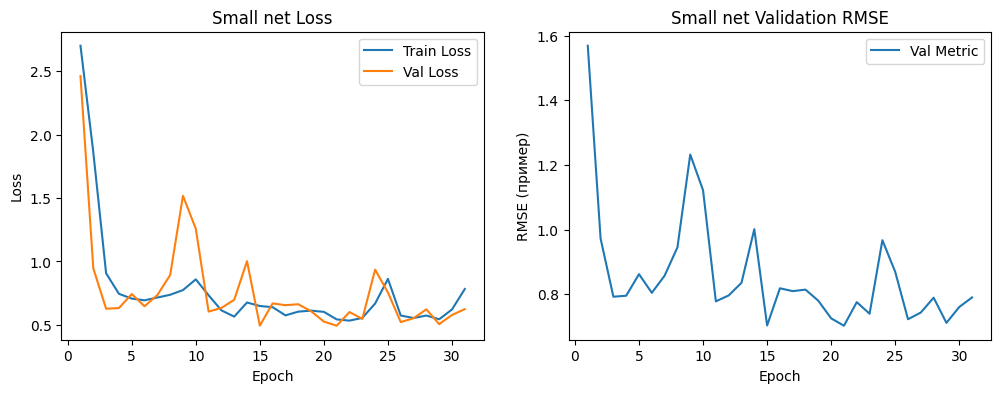

=== MEDIUM ===


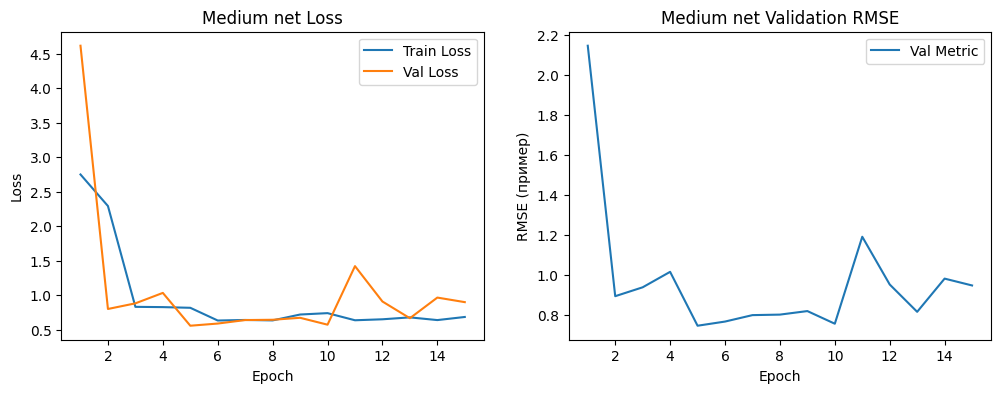

=== LARGE ===


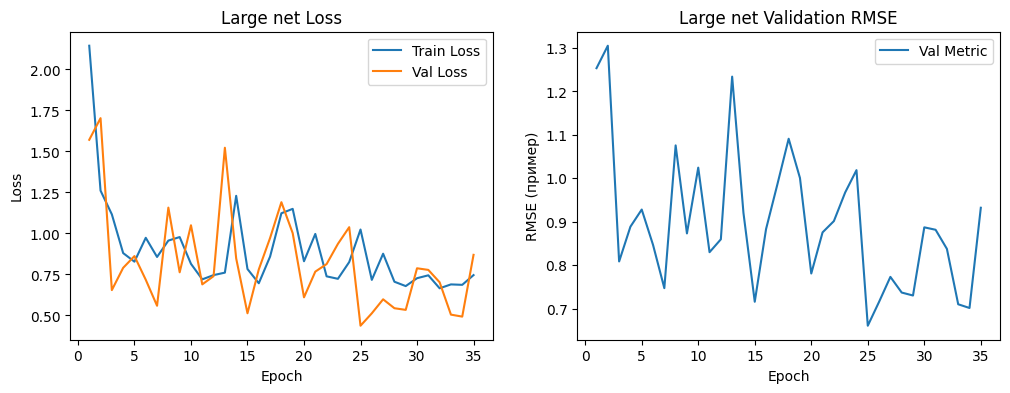

Small:  test RMSE = 0.7569
Medium: test RMSE = 0.7595
Large:  test RMSE = 0.6539


In [54]:
def plot_training(history, title="Model"):
    tr_loss, val_loss, val_met = history
    epochs = range(1, len(tr_loss) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.xlabel("Epoch");
    plt.ylabel("Loss")
    plt.title(f"{title} Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_met, label="Val Metric")
    plt.xlabel("Epoch");
    plt.ylabel("RMSE (пример)")
    plt.title(f"{title} Validation RMSE")
    plt.legend()
    plt.show()


print("=== SMALL ===")
plot_training(small_logs, title="Small net")
print("=== MEDIUM ===")
plot_training(medium_logs, title="Medium net")
print("=== LARGE ===")
plot_training(large_logs, title="Large net")



def evaluate_on_test(model, X_test, y_test, metric_func):
    model.evaluate()
    pred = model.forward(X_test)
    return metric_func(y_test.flatten(), pred.flatten())


rmse_small_test = evaluate_on_test(small_best, X_cal_test, y_cal_test, compute_rmse)
rmse_med_test = evaluate_on_test(medium_best, X_cal_test, y_cal_test, compute_rmse)
rmse_lrg_test = evaluate_on_test(large_best, X_cal_test, y_cal_test, compute_rmse)

print(f"Small:  test RMSE = {rmse_small_test:.4f}")
print(f"Medium: test RMSE = {rmse_med_test:.4f}")
print(f"Large:  test RMSE = {rmse_lrg_test:.4f}")

# MNIST

In [29]:
from sklearn.datasets import fetch_openml

mnist_raw = fetch_openml('mnist_784', version=1,as_frame=False)
X_mnist = mnist_raw['data'].astype(np.float32)
y_mnist = mnist_raw['target'].astype(np.int32)


X_mnist /= 255.0




X_mnist_train = X_mnist[:2000]
y_mnist_train = y_mnist[:2000]
X_mnist_val   = X_mnist[2000:2500]
y_mnist_val   = y_mnist[2000:2500]
X_mnist_test  = X_mnist[2500:3000]
y_mnist_test  = y_mnist[2500:3000]



def to_4d(X):
    return X.reshape(-1, 1, 28, 28)


X_mnist_train = to_4d(X_mnist_train)
X_mnist_val = to_4d(X_mnist_val)
X_mnist_test = to_4d(X_mnist_test)

print("MNIST:", X_mnist_train.shape, X_mnist_val.shape, X_mnist_test.shape)

MNIST: (2000, 1, 28, 28) (500, 1, 28, 28) (500, 1, 28, 28)


In [30]:
def build_mnist_cnn():
    model = Sequential()
    model.add(Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1))
    model.add(ReLU())
    model.add(MaxPool2d(kernel_size=2, stride=2, padding=0))  # 28->14
    model.add(Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1))
    model.add(ReLU())
    model.add(MaxPool2d(kernel_size=2, stride=2, padding=0))  # 14->7
    model.add(Flatten(start_dim=1, end_dim=-1))
    model.add(Linear(16 * 7 * 7, 128))
    model.add(ReLU())
    model.add(Linear(128, 10))
    model.add(LogSoftMax())
    return model


cnn_mnist = build_mnist_cnn()
print(cnn_mnist)

Conv2d
ReLU
MaxPool2d
Conv2d
ReLU
MaxPool2d
Flatten
Linear 784 -> 128
ReLU
Linear 128 -> 10
LogSoftMax



In [44]:
def to_one_hot(y, num_classes=10):
    N = y.shape[0]
    oh = np.zeros((N, num_classes), dtype=np.float32)
    oh[np.arange(N), y] = 1.0
    return oh


def train_classification_model(model,
                               X_train, y_train_idx,
                               X_val, y_val_idx,
                               criterion,  # ClassNLLCriterion
                               optimizer,
                               num_epochs=10,
                               batch_size=64,
                               warmup_epochs=2,
                               lr_decay_epochs=[5, 8],
                               lr_decay_factor=0.5,
                               patience=5):

    # one-hot
    y_train_oh = to_one_hot(y_train_idx, num_classes=10)
    y_val_oh = to_one_hot(y_val_idx, num_classes=10)

    train_loss_hist = []
    val_loss_hist = []
    val_acc_hist = []

    best_val_acc = 0.0
    best_model_state = None
    epochs_no_improve = 0

    base_lr = optimizer.lr
    initial_lr = base_lr / 10.0
    optimizer.lr = initial_lr

    N = X_train.shape[0]
    for epoch in range(1, num_epochs + 1):
        # Warmup
        if epoch <= warmup_epochs:
            prog = epoch / warmup_epochs
            optimizer.lr = initial_lr + (base_lr - initial_lr) * prog

        # Scheduler
        if epoch in lr_decay_epochs:
            optimizer.lr *= lr_decay_factor

        # TRAIN
        model.train()
        model.zeroGradParameters()
        indices = np.random.permutation(N)
        epoch_loss = 0.0
        for i in range(0, N, batch_size):
            b_idx = indices[i:i + batch_size]
            Xb = X_train[b_idx]
            yb_oh = y_train_oh[b_idx]

            out = model.forward(Xb)  # (batch,10) log probability
            loss = criterion.forward(out, yb_oh)
            epoch_loss += loss * len(b_idx)

            grad = criterion.backward(out, yb_oh)
            model.backward(Xb, grad)

            optimizer.step(model)

        epoch_loss /= N
        train_loss_hist.append(epoch_loss)

        # VAL
        model.evaluate()
        val_out = model.forward(X_val)
        val_loss = criterion.forward(val_out, y_val_oh)
        val_loss_hist.append(val_loss)

        # Accuracy
        pred_labels = np.argmax(val_out, axis=1)
        acc_val = compute_accuracy(y_val_idx, pred_labels)
        val_acc_hist.append(acc_val)

        if acc_val > best_val_acc:
            best_val_acc = acc_val
            best_model_state = copy.deepcopy(model)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(
            f"Epoch {epoch}, lr={optimizer.lr:.5f}, train_loss={epoch_loss:.4f}, val_loss={val_loss:.4f}, val_acc={acc_val * 100:.2f}%")

        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

    return best_model_state, (train_loss_hist, val_loss_hist, val_acc_hist)

Epoch 1, lr=0.00550, train_loss=2.2975, val_loss=2.2785, val_acc=22.80%
Epoch 2, lr=0.01000, train_loss=2.2633, val_loss=2.2176, val_acc=51.80%
Epoch 3, lr=0.01000, train_loss=2.1912, val_loss=2.1127, val_acc=65.00%
Epoch 4, lr=0.01000, train_loss=2.0625, val_loss=1.9071, val_acc=62.60%
Epoch 5, lr=0.00500, train_loss=1.8783, val_loss=1.7663, val_acc=67.40%
Epoch 6, lr=0.00500, train_loss=1.7235, val_loss=1.5892, val_acc=71.40%
Epoch 7, lr=0.00500, train_loss=1.5665, val_loss=1.4301, val_acc=68.00%
Epoch 8, lr=0.00250, train_loss=1.4277, val_loss=1.3521, val_acc=69.60%
Epoch 9, lr=0.00250, train_loss=1.3404, val_loss=1.2721, val_acc=71.60%
Epoch 10, lr=0.00250, train_loss=1.2696, val_loss=1.2135, val_acc=72.00%


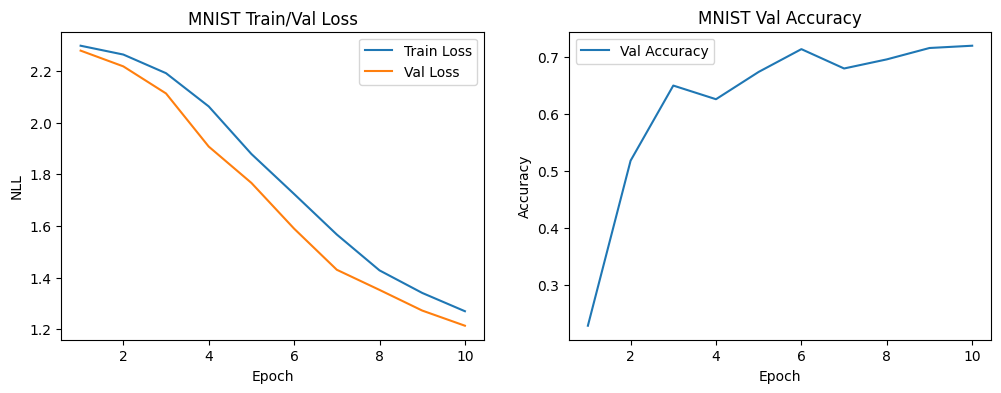

MNIST test accuracy: 74.80%


In [32]:
mnist_model = build_mnist_cnn()
optimizer_mnist = SGD(lr=0.01)
criterion_mnist = ClassNLLCriterion()

best_mnist, mnist_logs = train_classification_model(
    mnist_model,
    X_mnist_train, y_mnist_train,
    X_mnist_val, y_mnist_val,
    criterion=criterion_mnist,
    optimizer=optimizer_mnist,
    num_epochs=10,
    batch_size=64,
    warmup_epochs=2,
    lr_decay_epochs=[5, 8],
    lr_decay_factor=0.5,
    patience=5
)


tr_loss, val_loss, val_acc = mnist_logs
epochs = range(1, len(tr_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epoch");
plt.ylabel("NLL")
plt.title("MNIST Train/Val Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc, label="Val Accuracy")
plt.xlabel("Epoch");
plt.ylabel("Accuracy")
plt.title("MNIST Val Accuracy")
plt.legend()
plt.show()


best_mnist.evaluate()
out_test = best_mnist.forward(X_mnist_test)
pred_test = np.argmax(out_test, axis=1)
acc_test = compute_accuracy(y_mnist_test, pred_test)
print(f"MNIST test accuracy: {acc_test * 100:.2f}%")

# Autoencoder

In [69]:
class FlattenAE(Module):
    """Simple version Flatten (batch,1,28,28)->(batch,784)."""

    def __init__(self):
        super(FlattenAE, self).__init__()
        self.input_shape = None

    def updateOutput(self, input):
        self.input_shape = input.shape
        batch_size = input.shape[0]
        self.output = input.reshape(batch_size, -1)  # (batch,784)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput.reshape(self.input_shape)
        return self.gradInput

    def __repr__(self):
        return "FlattenAE"


class ReshapeAE(Module):
    """Reverse transformation (batch,784)->(batch,1,28,28)."""

    def __init__(self, out_shape):
        super(ReshapeAE, self).__init__()
        self.out_shape = out_shape
        self.in_shape = None

    def updateOutput(self, input):
        self.in_shape = input.shape
        batch_size = input.shape[0]
        self.output = input.reshape((batch_size,) + self.out_shape)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput.reshape(self.in_shape)
        return self.gradInput

    def __repr__(self):
        return f"ReshapeAE({self.out_shape})"


In [ ]:
def build_autoencoder_fc(latent_dim=64):
    model = Sequential()
    # ENCODER
    model.add(FlattenAE())  # (batch,1,28,28)->(batch,784)
    model.add(Linear(784, 256))
    model.add(ReLU())
    model.add(Linear(256, 128))
    model.add(ReLU())
    model.add(Linear(128, latent_dim))
    model.add(ReLU())
    # DECODER
    model.add(Linear(latent_dim, 128))
    model.add(ReLU())
    model.add(Linear(128, 256))
    model.add(ReLU())
    model.add(Linear(256, 784))

    class Sigmoid(Module):
        def updateOutput(self, input):
            self.output = 1.0/(1.0+np.exp(-input))
            return self.output
        def updateGradInput(self, input, gradOutput):
            sig = self.output
            self.gradInput = gradOutput*sig*(1.0-sig)
            return self.gradInput

    model.add(Sigmoid())
    model.add(ReshapeAE((1,28,28)))
    return model

In [71]:
def train_autoencoder(model,
                      X_train, X_val,
                      criterion,  # MSECriterion
                      optimizer,
                      num_epochs=10,
                      batch_size=64,
                      warmup_epochs=2,
                      lr_decay_epochs=[5, 8],
                      lr_decay_factor=0.5,
                      patience=5):
    """
    Autoencoder training (X->X), loss=MSE by pixels.
    """
    train_loss_hist = []
    val_loss_hist = []

    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    base_lr = optimizer.lr
    initial_lr = base_lr / 10.0
    optimizer.lr = initial_lr

    N = X_train.shape[0]
    for epoch in range(1, num_epochs + 1):
        # Warmup
        if epoch <= warmup_epochs:
            prog = epoch / warmup_epochs
            optimizer.lr = initial_lr + (base_lr - initial_lr) * prog

        # Scheduler
        if epoch in lr_decay_epochs:
            optimizer.lr *= lr_decay_factor

        # TRAIN
        model.train()
        model.zeroGradParameters()
        indices = np.random.permutation(N)
        epoch_loss = 0.0
        for i in range(0, N, batch_size):
            b_idx = indices[i:i + batch_size]
            Xb = X_train[b_idx]

            out = model.forward(Xb)
            loss = criterion.forward(out, Xb)
            epoch_loss += loss * len(b_idx)

            grad = criterion.backward(out, Xb)
            model.backward(Xb, grad)

            optimizer.step(model)

        epoch_loss /= N
        train_loss_hist.append(epoch_loss)

        # VAL
        model.evaluate()
        out_val = model.forward(X_val)
        val_loss = criterion.forward(out_val, X_val)
        val_loss_hist.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f"Epoch {epoch}, lr={optimizer.lr:.5f}, train_loss={epoch_loss:.4f}, val_loss={val_loss:.4f}")

        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

    return best_model_state, (train_loss_hist, val_loss_hist)


Epoch 1, lr=0.00550, train_loss=158.6097, val_loss=68.3410
Epoch 2, lr=0.01000, train_loss=61.1067, val_loss=57.7191
Epoch 3, lr=0.01000, train_loss=55.0395, val_loss=55.6025
Epoch 4, lr=0.01000, train_loss=53.1982, val_loss=53.5593
Epoch 5, lr=0.00500, train_loss=51.6576, val_loss=51.9293
Epoch 6, lr=0.00500, train_loss=50.4188, val_loss=51.5311
Epoch 7, lr=0.00500, train_loss=49.9908, val_loss=50.8460
Epoch 8, lr=0.00250, train_loss=49.2245, val_loss=49.5545
Epoch 9, lr=0.00250, train_loss=48.2003, val_loss=48.9187
Epoch 10, lr=0.00250, train_loss=47.6318, val_loss=48.5830
Epoch 11, lr=0.00250, train_loss=47.2922, val_loss=48.4021
Epoch 12, lr=0.00250, train_loss=47.1287, val_loss=48.1103
Epoch 13, lr=0.00250, train_loss=47.0573, val_loss=48.0905
Epoch 14, lr=0.00250, train_loss=46.8604, val_loss=47.7621
Epoch 15, lr=0.00250, train_loss=46.7303, val_loss=47.7640
Epoch 16, lr=0.00250, train_loss=46.6141, val_loss=47.4270
Epoch 17, lr=0.00250, train_loss=46.4030, val_loss=47.2450
Epoch

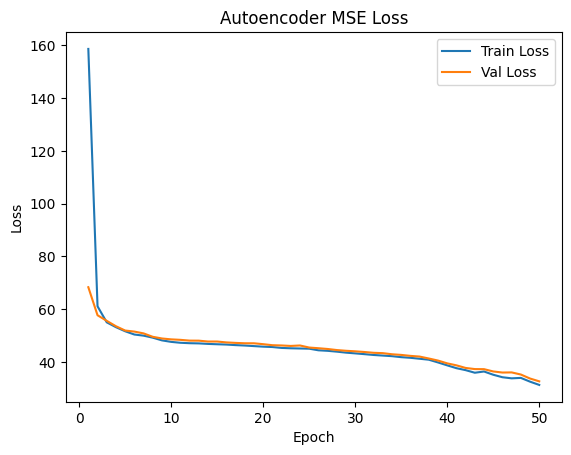

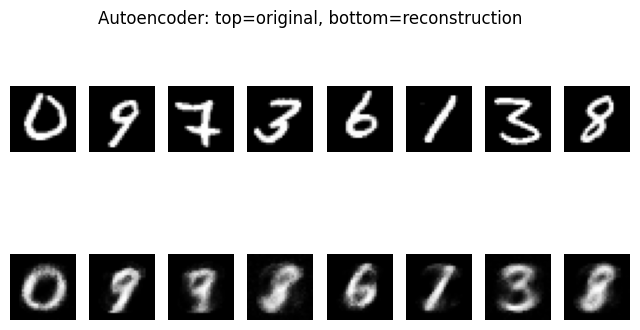

In [43]:
autoenc = build_autoencoder_fc(latent_dim=256)
optimizer_ae = SGD(lr=0.01)
criterion_ae = MSECriterion()

best_ae, ae_logs = train_autoencoder(
    autoenc,
    X_mnist_train, X_mnist_val,
    criterion_ae,
    optimizer_ae,
    num_epochs=50,
    batch_size=128,
    warmup_epochs=2,
    lr_decay_epochs=[5, 8],
    lr_decay_factor=0.5,
    patience=5
)

tr_loss_ae, val_loss_ae = ae_logs
epochs = range(1, len(tr_loss_ae) + 1)
plt.figure()
plt.plot(epochs, tr_loss_ae, label="Train Loss")
plt.plot(epochs, val_loss_ae, label="Val Loss")
plt.title("Autoencoder MSE Loss")
plt.xlabel("Epoch");
plt.ylabel("Loss")
plt.legend()
plt.show()


best_ae.evaluate()
X_test_ae = X_mnist_test[:8]  # first 8 pictures
out_test_ae = best_ae.forward(X_test_ae)  # (8,1,28,28)

plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 8, i + 1)
    plt.imshow(X_test_ae[i, 0], cmap='gray')
    plt.axis('off')
    plt.subplot(2, 8, i + 1 + 8)
    plt.imshow(out_test_ae[i, 0], cmap='gray')
    plt.axis('off')
plt.suptitle("Autoencoder: top=original, bottom=reconstruction")
plt.show()

Now let's add convolutional layers, BatchNorm, Dropout.

In [76]:
def build_autoencoder_fc(latent_dim=32):
    model = Sequential()

    # Encoder
    model.add(Conv2d(in_channels=1, out_channels=2, kernel_size=3, padding=1))
    model.add(ReLU())
    model.add(Dropout(0.1))
    # Flatten
    model.add(FlattenAE())
    # BatchNorm
    model.add(BatchNormalization())
    model.add(ReLU())
    # Linear
    model.add(Linear(2*28*28, 128))
    model.add(ReLU())
    model.add(Linear(128, latent_dim))
    model.add(ReLU())

    # Decoder
    model.add(Linear(latent_dim, 128))
    model.add(ReLU())
    model.add(Linear(128, 2*28*28))
    model.add(ReLU())
    model.add(ReshapeAE((2, 28, 28)))
    # BatchNorm
    model.add(Conv2d(in_channels=2, out_channels=1, kernel_size=3, padding=1))
    class Sigmoid(Module):
        def updateOutput(self, input):
            self.output = 1.0/(1.0+np.exp(-input))
            return self.output
        def updateGradInput(self, input, gradOutput):
            sig = self.output
            self.gradInput = gradOutput*sig*(1.0 - sig)
            return self.gradInput
    model.add(Sigmoid())

    return model

Epoch 1, lr=0.00055, train_loss=202.2727, val_loss=201.3780
Epoch 2, lr=0.00100, train_loss=200.6485, val_loss=197.2457
Epoch 3, lr=0.00100, train_loss=182.0731, val_loss=92.8315
Epoch 4, lr=0.00100, train_loss=70.8456, val_loss=62.3675
Epoch 5, lr=0.00050, train_loss=59.5619, val_loss=59.4067
Epoch 6, lr=0.00050, train_loss=57.8651, val_loss=58.6367
Epoch 7, lr=0.00050, train_loss=57.2344, val_loss=58.1260
Epoch 8, lr=0.00025, train_loss=56.8825, val_loss=57.9443
Epoch 9, lr=0.00025, train_loss=56.4994, val_loss=57.3847
Epoch 10, lr=0.00025, train_loss=56.3608, val_loss=57.3949


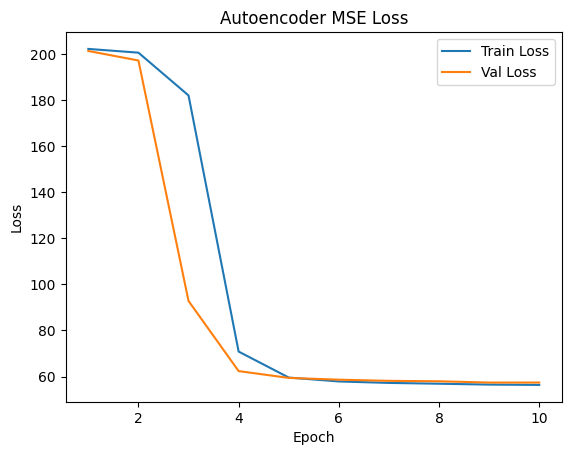

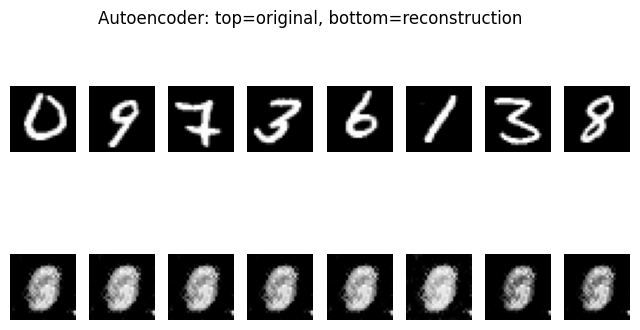

In [79]:
autoenc = build_autoencoder_fc(latent_dim=256)
optimizer_ae = SGD(lr=0.001)
criterion_ae = MSECriterion()

best_ae, ae_logs = train_autoencoder(
    autoenc,
    X_mnist_train, X_mnist_val,
    criterion_ae,
    optimizer_ae,
    num_epochs=10,
    batch_size=128,
    warmup_epochs=2,
    lr_decay_epochs=[5, 8],
    lr_decay_factor=0.5,
    patience=5
)

tr_loss_ae, val_loss_ae = ae_logs
epochs = range(1, len(tr_loss_ae) + 1)
plt.figure()
plt.plot(epochs, tr_loss_ae, label="Train Loss")
plt.plot(epochs, val_loss_ae, label="Val Loss")
plt.title("Autoencoder MSE Loss")
plt.xlabel("Epoch");
plt.ylabel("Loss")
plt.legend()
plt.show()


best_ae.evaluate()
X_test_ae = X_mnist_test[:8]  # first 8 pictures
out_test_ae = best_ae.forward(X_test_ae)  # (8,1,28,28)

plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 8, i + 1)
    plt.imshow(X_test_ae[i, 0], cmap='gray')
    plt.axis('off')
    plt.subplot(2, 8, i + 1 + 8)
    plt.imshow(out_test_ae[i, 0], cmap='gray')
    plt.axis('off')
plt.suptitle("Autoencoder: top=original, bottom=reconstruction")
plt.show()